In [1]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from category_encoders import TargetEncoder

## 加载数据

In [2]:
df_train = pd.read_csv('./data/used_car_train_20200313.csv', sep=' ')
df_train['is_train'] = 1
df_test = pd.read_csv('./data/used_car_testB_20200421.csv', sep=' ')
df_test['is_train'] = 0

## 清洗异常数据

In [3]:
date_feature = ['regDate', 'creatDate']


def clean_error_month(x):
    '''
    清洗日期中月份出现错误的数据 将00->01
    '''
    x = str(x)
    if len(x) != 8:
        return pd.NaT
    if x[4:6] == '00':
        x = x[:4]+'01'+x[6:]
    return x


for feature in date_feature:
    df_train[feature] = df_train[feature].apply(clean_error_month)
    df_test[feature] = df_test[feature].apply(clean_error_month)

## 缺失值按众数填充

In [4]:
df_train['model'] = df_train['model'].fillna(0)
df_train['bodyType'] = df_train['bodyType'].fillna(0)
df_train['fuelType'] = df_train['fuelType'].fillna(0)
df_train['gearbox'] = df_train['gearbox'].fillna(0)
df_train['power'] = df_train['power'].where(df_train['power'] <= 600, 600)
df_train['notRepairedDamage'] = df_train['notRepairedDamage'].replace('-','0').astype('float')

df_test['bodyType'] = df_test['bodyType'].fillna(0)
df_test['fuelType'] = df_test['fuelType'].fillna(0)
df_test['gearbox'] = df_test['gearbox'].fillna(0)
df_test['power'] = df_test['power'].where(df_test['power'] <= 600, 600)
df_test['notRepairedDamage'] = df_test['notRepairedDamage'].replace('-','0').astype('float')

## 删除异常数据，注意只能删除训练集的数据，测试集数据是不能删除的

### 异常值是去除了 但是泛化能力如何未知

In [5]:
# 使用【Q1-1.5IQR,Q3+1.5IQR】
# 数值型变量
numeric_features = ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
                    'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']

# 类别型变量
categorical_features = ['name', 'model', 'brand', 'bodyType',
                        'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode']
# 日期型变量
date_features = ['regDate', 'creatDate']

# 异常数据处理
rules = []
for feature in numeric_features:
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    IQR = Q3-Q1
    min_border = Q1-3*IQR
    max_border = Q3+3*IQR
    rules.append((feature, min_border, max_border))

for rule in rules:
    feature, min_border, max_border = rule
    df_train = df_train[(df_train[feature] <= max_border)
                        & (df_train[feature] >= min_border)]
print(rules)
print(df_train.shape)

[('power', -150.0, 375.0), ('kilometer', 5.0, 22.5), ('v_0', 34.529032837029035, 54.61148694308912), ('v_1', -24.771406530326573, 25.579727039608933), ('v_2', -4.6066893586405095, 3.877353010397744), ('v_3', -10.547834780426866, 10.651092938134394), ('v_4', -6.291041241411207, 6.238608193093828), ('v_5', 0.17856963440459794, 0.3303429780583119), ('v_6', -0.30587544909826125, 0.4079228577934537), ('v_7', -0.12583470406303585, 0.31355118168333285), ('v_8', -0.0968099654191358, 0.2115252229764337), ('v_9', -0.12675093714507132, 0.24817166246381298), ('v_10', -23.42228184908801, 22.544335744507364), ('v_11', -11.571237001545057, 10.874715651396418), ('v_12', -12.818181892195142, 12.723269080200502), ('v_13', -7.059595184882333, 6.94461928314752), ('v_14', -3.78926889659761, 4.0326133029067375)]
(134288, 32)


In [6]:
# 合并数据集
df = pd.concat([df_train, df_test],axis=0)
df.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,is_train
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,1
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,1
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1


In [7]:
df['price']

0        1850.0
1        3600.0
2        6222.0
3        2400.0
4        5200.0
          ...  
49995       NaN
49996       NaN
49997       NaN
49998       NaN
49999       NaN
Name: price, Length: 184288, dtype: float64

## 特征构建

### price做对数变换

In [8]:
df['price'] = np.log(df['price'])

In [9]:
df['price']

0        7.522941
1        8.188689
2        8.735847
3        7.783224
4        8.556414
           ...   
49995         NaN
49996         NaN
49997         NaN
49998         NaN
49999         NaN
Name: price, Length: 184288, dtype: float64

In [8]:
def my_agg(data, dim, measure='price'):
    '''
    按照指定维度聚合并重命名,暂时维度只有1
    '''
    index = ['min', 'max', 'mean', 'median','sum', 'std', 'kurt', 'skew']
    new_columns = [dim]+list(map(lambda x: f'{dim}_{measure}_{x}', index))
    new_df = data.groupby(dim).agg({
        measure: ['min', 'max', 'mean', 'median', 'sum', 'std', pd.DataFrame.kurt, pd.DataFrame.skew]
    }).reset_index()
    new_df.columns = new_columns
    return new_df

### name字段处理（高基类别特征 使用target encoder进行编码）

In [9]:
df['name_count'] = df.groupby('name')['SaleID'].transform('count')
name_price_df = my_agg(df[df['is_train'] == 1], 'name')
df = pd.merge(df, name_price_df, on='name', how='left')
df.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,is_train,name_count,name_price_min,name_price_max,name_price_mean,name_price_median,name_price_sum,name_price_std,name_price_kurt,name_price_skew
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,1,107,4.605170,8.366370,7.491089,7.696213,576.813887,0.644793,5.358013,-1.904974
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,1,29,5.703782,9.698920,7.727050,7.649693,146.813941,0.979271,0.049150,-0.052624
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,1,2,8.735847,8.735847,8.735847,8.735847,8.735847,NaN,NaN,NaN
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,1,2,7.783224,8.682708,8.232966,8.232966,16.465932,0.636031,NaN,NaN
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,1,1,8.556414,8.556414,8.556414,8.556414,8.556414,NaN,NaN,NaN


### 处理区域编码(高基类别特征 使用target encoder进行编码）

In [10]:
df['region_count'] = df.groupby('regionCode')['SaleID'].transform('count')
region_price_df = my_agg(df[df['is_train'] == 1], 'regionCode')
df = pd.merge(df, region_price_df, on='regionCode', how='left')
# df.head()

### 处理model(高基类别特征-车型编码)

In [11]:
df['model_count'] = df.groupby('model')['SaleID'].transform('count')
model_price_df = my_agg(df[df['is_train'] == 1], 'model')
df = pd.merge(df, model_price_df, on='model', how='left')
# df.head()

### 处理brand(高基类别特征40)

In [12]:
# 量
df['brand_count'] = df.groupby('brand')['SaleID'].transform('count')
brand_price_df = my_agg(df[df['is_train'] == 1], 'brand')
df = pd.merge(df, brand_price_df, on='brand', how='left')
# df.head()

### 处理bodyType(可以onehot)

In [13]:
df['bodyType_count'] = df.groupby('bodyType')['SaleID'].transform('count')
bodyType_price_df = my_agg(df[df['is_train'] == 1], 'bodyType')
df = pd.merge(df, bodyType_price_df, on='bodyType', how='left')
tmp_df = pd.get_dummies(df['bodyType'], prefix='bodyType')
df = pd.concat([df, tmp_df], axis=1)

### 处理fuelType

In [14]:
df['fuelType_count'] = df.groupby('fuelType')['SaleID'].transform('count')
fuelType_price_df = my_agg(df[df['is_train'] == 1], 'fuelType')
df = pd.merge(df, fuelType_price_df, on='fuelType', how='left')
tmp_df = pd.get_dummies(df['fuelType'], prefix='fuelType')
df = pd.concat([df, tmp_df], axis=1)
# df.head()

### 处理gearbox

In [15]:
df['gearbox_count'] = df.groupby('gearbox')['SaleID'].transform('count')
gearbox_price_df = my_agg(df[df['is_train'] == 1], 'gearbox')
df = pd.merge(df, gearbox_price_df, on='gearbox', how='left')
tmp_df = pd.get_dummies(df['gearbox'], prefix='gearbox')
df = pd.concat([df, tmp_df], axis=1)
# df.head()

### 处理kilometer

In [16]:
df['kilometer_count'] = df.groupby('kilometer')['SaleID'].transform('count')
kilometer_price_df = my_agg(df[df['is_train'] == 1], 'kilometer')
df = pd.merge(df, kilometer_price_df, on='kilometer', how='left')
# df.head()

### 处理notRepairedDamage

In [17]:
df['notRepairedDamage_count'] = df.groupby('notRepairedDamage')['SaleID'].transform('count')
notRepairedDamage_price_df = my_agg(df[df['is_train'] == 1], 'notRepairedDamage')
df = pd.merge(df, notRepairedDamage_price_df, on='notRepairedDamage', how='left')
tmp_df = pd.get_dummies(df['notRepairedDamage'], prefix='notRepairedDamage')
df = pd.concat([df, tmp_df], axis=1)
# df.head()

### 处理时间特征

In [18]:
df['used_days'] = (pd.to_datetime(df['creatDate'], format='%Y%m%d') -
                   pd.to_datetime(df['regDate'], format='%Y%m%d')).dt.days
df['used_years'] = round(df['used_days']/365, 1)

df['kilometer_div_years'] = df['kilometer']/df['used_years']
df['kilometer_div_days'] = df['kilometer']/df['used_days']

In [19]:
# 对使用天数进行分箱
df['use_days_bin_20'] = pd.qcut(df['used_days'], 20, labels=False)
use_days_bin_20_price_df = my_agg(df[df['is_train'] == 1], 'use_days_bin_20')
df = pd.merge(df, use_days_bin_20_price_df, on='use_days_bin_20', how='left')
df.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,kilometer_div_days,use_days_bin_20,use_days_bin_20_price_min,use_days_bin_20_price_max,use_days_bin_20_price_mean,use_days_bin_20_price_median,use_days_bin_20_price_sum,use_days_bin_20_price_std,use_days_bin_20_price_kurt,use_days_bin_20_price_skew
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.002851,9,4.595120,11.047710,8.007563,8.006034,54923.877580,0.696483,0.719207,-0.095323
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.003153,10,4.094345,10.817997,7.830263,7.824046,54122.777003,0.714037,0.888213,-0.169502
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.002853,9,4.595120,11.047710,8.007563,8.006034,54923.877580,0.696483,0.719207,-0.095323
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.002105,18,2.708050,11.383955,6.802557,6.745236,46270.990905,0.931924,1.594537,0.452591
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.003266,0,4.762174,11.367900,9.607767,9.667132,52160.569393,0.577072,5.924422,-1.118528


### 匿名特征处理

In [20]:
# 根据分箱对租金进行进行特征组合
features_list = ['v_0', 'v_2', 'v_8', 'v_12', 'v_3']
for i in features_list:
    feature = f'box_{i}'
    df[f'box_{i}'] = pd.qcut(df[i], 20, duplicates='drop', labels=False)
    tmp_df = my_agg(df[df['is_train'] == 1], feature)
    df = pd.merge(df, tmp_df, on=feature, how='left')
    del df[f'box_{i}']
df.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,box_v_12_price_kurt,box_v_12_price_skew,box_v_3_price_min,box_v_3_price_max,box_v_3_price_mean,box_v_3_price_median,box_v_3_price_sum,box_v_3_price_std,box_v_3_price_kurt,box_v_3_price_skew
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,2.596714,0.869444,4.595120,9.615805,6.969457,6.907755,47266.859089,0.504370,2.170832,0.446452
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,1.347717,0.471035,4.605170,9.680281,7.314940,7.306531,50385.308442,0.494600,1.262538,0.409478
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,1.380091,0.617911,6.214608,10.887437,8.564083,8.556222,58064.480896,0.421796,1.170034,0.329916
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,1.703044,0.710873,5.135798,9.952278,7.645667,7.600402,51715.289075,0.510328,1.273058,0.501771
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,1.293966,0.835526,6.907755,10.985293,8.888853,8.881836,60453.087057,0.394190,0.662993,0.305500


In [21]:
# 匿名特征之间的组合
for i in range(15):
    for j in range(i+1, 15):
        df[f'v_{i}_add_v_{j}'] = df[f'v_{i}']+df[f'v_{j}']
        df[f'v_{i}_minus_v_{j}'] = df[f'v_{i}']-df[f'v_{j}']
        df[f'v_{i}_multiply_v_{j}'] = df[f'v_{i}']*df[f'v_{j}']
        df[f'v_{i}_div_v_{j}'] = df[f'v_{i}']/df[f'v_{j}']
df.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_12_multiply_v_13,v_12_div_v_13,v_12_add_v_14,v_12_minus_v_14,v_12_multiply_v_14,v_12_div_v_14,v_13_add_v_14,v_13_minus_v_14,v_13_multiply_v_14,v_13_div_v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,-1.925259,-3.043940,-1.506058,-3.335583,-2.214476,-2.646393,1.710054,-0.119471,0.727503,0.869397
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,1.775186,0.598188,-0.784960,-1.276005,-0.253007,-4.197103,-1.477151,-1.968196,-0.422955,-7.016361
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,-1.303430,-1.879853,1.335367,1.795292,-0.359968,-6.806880,-1.062650,-0.602724,0.191487,3.620964
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,1.223731,0.205823,-0.980567,-0.023169,0.240244,1.048399,-2.917052,-1.959653,1.167238,5.093704
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,2.639247,0.328490,2.854592,-0.992372,1.790972,0.484075,4.758000,0.911036,5.452144,1.473639


In [22]:
df_train = df[df['is_train']==1]
df_test = df[df['is_train']==0]
print(df_train.shape)
print(df_test.shape)

(134288, 605)
(50000, 605)


In [23]:
y_train = df_train['price']

enc = TargetEncoder(cols=['name','regionCode','model','brand'])

df_train = enc.fit_transform(df_train,y_train)
df_test = enc.transform(df_test)

In [24]:
# 删除无效特征
delete_features = ['SaleID','regDate','offerType','seller','bodyType','fuelType','gearbox','notRepairedDamage','creatDate','is_train']
for feature in delete_features:
    del df_train[feature]
    del df_test[feature]
del df_test['price']

In [25]:
for column in df_train.columns:
    print(column)

name
model
brand
power
kilometer
regionCode
price
v_0
v_1
v_2
v_3
v_4
v_5
v_6
v_7
v_8
v_9
v_10
v_11
v_12
v_13
v_14
name_count
name_price_min
name_price_max
name_price_mean
name_price_median
name_price_sum
name_price_std
name_price_kurt
name_price_skew
region_count
regionCode_price_min
regionCode_price_max
regionCode_price_mean
regionCode_price_median
regionCode_price_sum
regionCode_price_std
regionCode_price_kurt
regionCode_price_skew
model_count
model_price_min
model_price_max
model_price_mean
model_price_median
model_price_sum
model_price_std
model_price_kurt
model_price_skew
brand_count
brand_price_min
brand_price_max
brand_price_mean
brand_price_median
brand_price_sum
brand_price_std
brand_price_kurt
brand_price_skew
bodyType_count
bodyType_price_min
bodyType_price_max
bodyType_price_mean
bodyType_price_median
bodyType_price_sum
bodyType_price_std
bodyType_price_kurt
bodyType_price_skew
bodyType_0.0
bodyType_1.0
bodyType_2.0
bodyType_3.0
bodyType_4.0
bodyType_5.0
bodyType_6.0
bodyT

### TODO 可以尝试非金额统计度量做组合特征

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134288 entries, 0 to 134287
Columns: 595 entries, name to v_13_div_v_14
dtypes: float64(564), int64(12), uint8(19)
memory usage: 598.6 MB


## 内存优化

In [27]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem/1024/1024))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem/1024/1024))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [28]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 598.59 MB
Memory usage after optimization is: 197.23 MB
Decreased by 67.1%
Memory usage of dataframe is 220.63 MB
Memory usage after optimization is: 70.43 MB
Decreased by 68.1%


## 输出

In [29]:
df_train.to_csv('user_data/train_tree.csv',index=False)
df_test.to_csv('user_data/test_tree.csv',index=False)
print('树模型特征工程已完成')

树模型特征工程已完成


In [30]:
df_train.memory_usage().sum()/1024/1024

197.2285919189453

In [31]:
print(df_train.shape)

(134288, 595)


In [34]:
df_train = pd.read_csv('./data/used_car_train_20200313.csv', sep=' ')

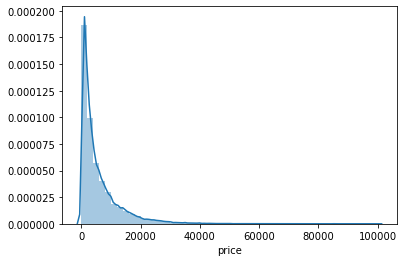

In [36]:
sns.distplot(df_train['price'])